# Gen AI Genesis - PancrAI

Data Combining

In [ ]:
import pandas as pd
from functools import reduce

# Step 1: Load NHANES .xpt files
file_paths = {
    "DEMO": "DEMO_J.xpt",
    "ALQ": "ALQ_J.xpt",
    "SMQ": "SMQ_J.xpt",
    "PAQ": "PAQ_J.xpt",
    "DIQ": "DIQ_J.xpt",
    "HIQ": "HIQ_J.xpt",
    "BMX": "BMX_J.xpt",
    "DR1TOT": "DR1TOT_J.xpt",
    "WHQ": "WHQ_J.xpt"
}

# Read each file as a DataFrame and store them in a dictionary
datasets = {key: pd.read_sas(path, format='xport') for key, path in file_paths.items()}

# Merge all the datasets on SEQN (ensuring data stays aligned by participant)
nhanes = reduce(lambda left, right: pd.merge(left, right, on="SEQN", how="inner"), datasets.values())

# Step 2: Clean & Standardize Columns
nhanes = nhanes.rename(columns={
    "RIAGENDR": "Gender",
    "RIDAGEYR": "Age",
    "WHQ030": "Obesity",
    "SMQ020": "Smoking_History",
    "ALQ111": "Alcohol_Consumption",
    "DIQ010": "Diabetes",
    "PAQ605": "Physical_Activity_Level",
    "HIQ011": "Access_to_Healthcare",
})

# Map and clean each column to match cancer dataset format
nhanes["Gender"] = nhanes["Gender"].map({1: "Male", 2: "Female"})
nhanes["Obesity"] = nhanes["Obesity"].apply(lambda x: 1 if x == 1 else 0)
nhanes["Smoking_History"] = nhanes["Smoking_History"].map({1: 1, 2: 0})
nhanes["Alcohol_Consumption"] = nhanes["Alcohol_Consumption"].map({1: 1, 2: 0})
nhanes["Diabetes"] = nhanes["Diabetes"].map({1: 1}).fillna(0)
nhanes["Physical_Activity_Level"] = nhanes["Physical_Activity_Level"].map({1: "High", 2: "Low"})
nhanes["Access_to_Healthcare"] = nhanes["Access_to_Healthcare"].map({1: "High", 2: "Low"})

# Add label
nhanes["Cancer_Status"] = 0

# Columns to keep (must match cancer dataset)
columns = [
    "Age", "Gender", "Obesity", "Smoking_History", "Alcohol_Consumption", "Diabetes",
    "Physical_Activity_Level", "Access_to_Healthcare", "Cancer_Status"
]

# Subset the dataframe
nhanes_clean = nhanes[columns].copy()

# Step 3: Fix missing values
# Fill numerical columns with median, categorical with most common value
nhanes_clean["Alcohol_Consumption"].fillna(0, inplace=True)
nhanes_clean["Access_to_Healthcare"].fillna("Medium", inplace=True)
nhanes_clean["Physical_Activity_Level"].fillna("Medium", inplace=True)

# Step 4: Load and clean the pancreatic cancer dataset
cancer_df = pd.read_csv("pancreatic_cancer_prediction_sample.csv")

# Match column names and format
cancer_df = cancer_df[columns[:-1]].copy()
cancer_df["Cancer_Status"] = 1
cancer_df.dropna(inplace=True)

# Step 5: Balance dataset based on the smaller group
min_size = min(len(nhanes_clean), len(cancer_df))
nhanes_balanced = nhanes_clean.sample(n=min_size, random_state=42)
cancer_balanced = cancer_df.sample(n=min_size, random_state=42)

# Step 6: Combine and save the final dataset
final_df = pd.concat([nhanes_balanced, cancer_balanced], ignore_index=True)

final_df.to_csv("final_balanced_dataset.csv", index=False)

print(f"Final dataset saved: {final_df.shape[0]} rows (Cancer: {min_size}, Healthy: {min_size})")


<ipython-input-2-fdc3747f6f8c>:58: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nhanes_clean["Alcohol_Consumption"].fillna(0, inplace=True)
<ipython-input-2-fdc3747f6f8c>:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

Final dataset saved: 11066 rows (Cancer: 5533, Healthy: 5533)


Data Pre-processing

Saved as final_training_ready_dataset.csv with shape: (11066, 9)


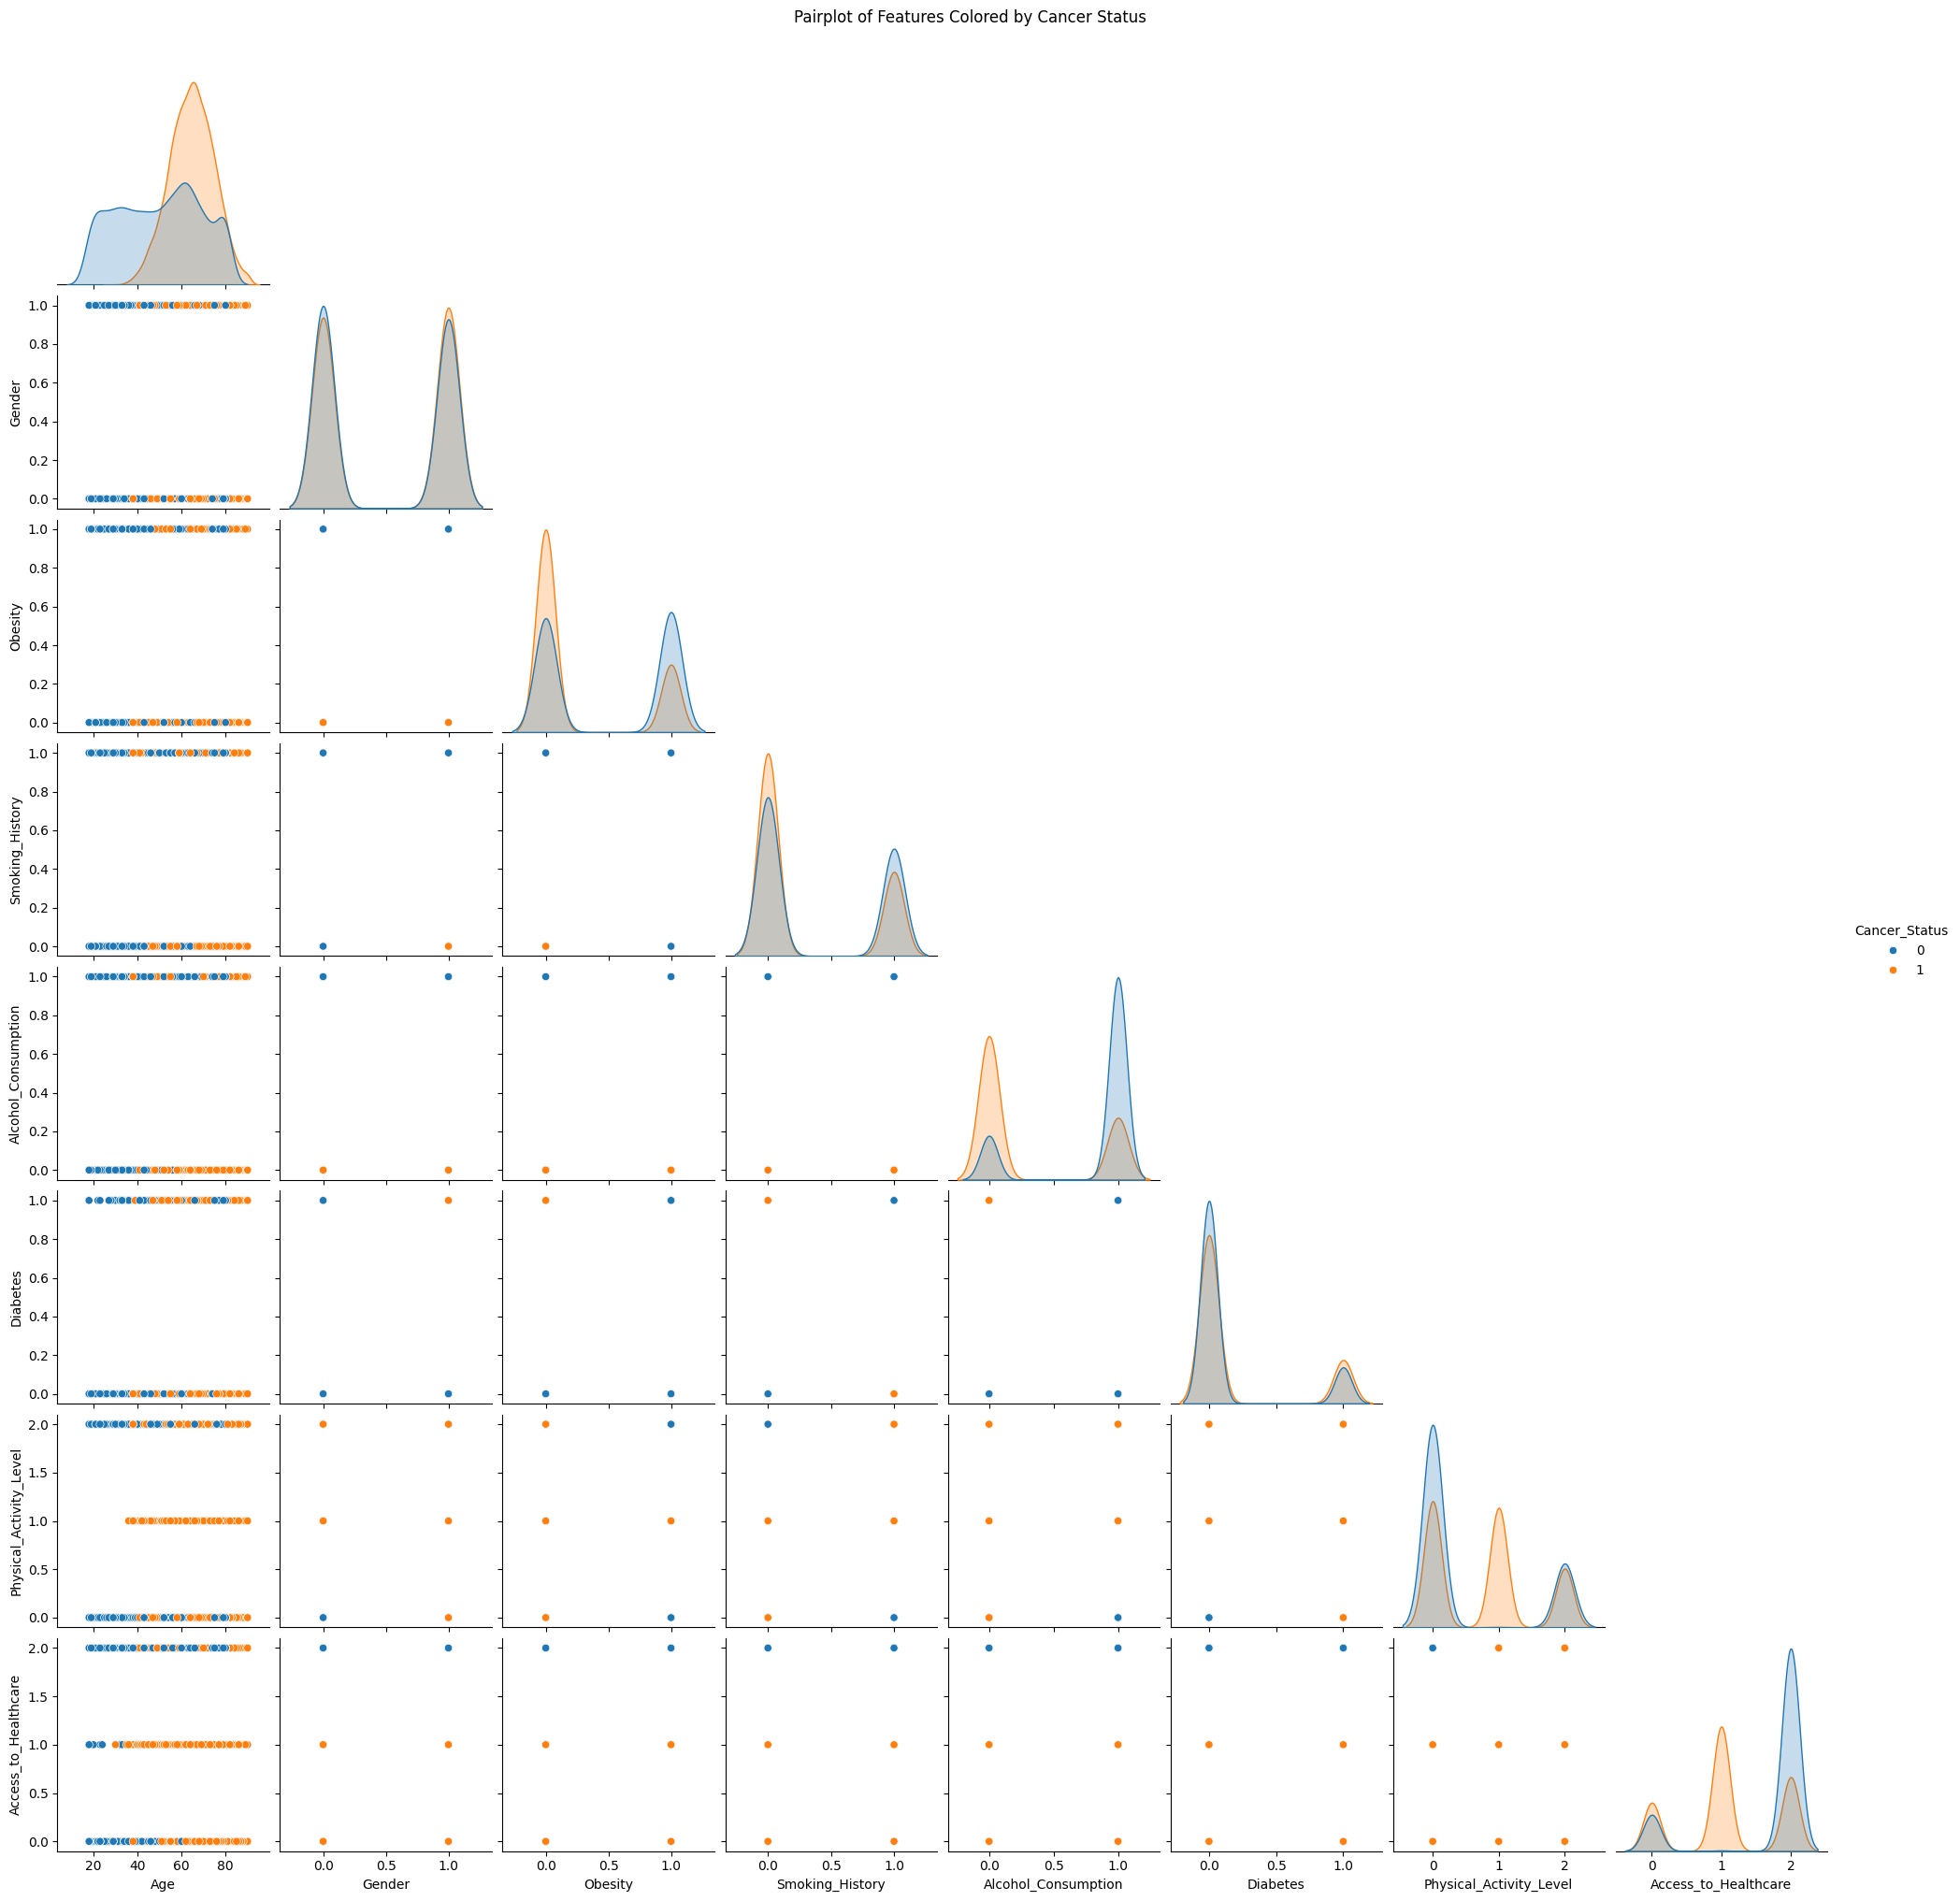

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the dataset
df = pd.read_csv("final_balanced_dataset.csv")

# Step 2: Map categorical values
label_map = {
    "Gender": {"Male": 1, "Female": 0},
    "Physical_Activity_Level": {"High": 2, "Medium": 1, "Low": 0},
    "Access_to_Healthcare": {"High": 2, "Medium": 1, "Low": 0}
}

for col, mapping in label_map.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)

# Step 3: Ensure numeric types
# Obesity is already binary (0 or 1), but ensure float type
for col in df.columns:
    if col == "Cancer_Status":
        df[col] = df[col].astype(int)
    else:
        df[col] = df[col].astype(float)

# Step 4: Shuffle the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 5: Save the preprocessed dataset
df.to_csv("final_training_ready_dataset.csv", index=False)
print("Saved as final_training_ready_dataset.csv with shape:", df.shape)

# Step 6: Plot visual correlations (optional but awesome!)
sns.pairplot(df, hue="Cancer_Status", diag_kind="kde", corner=True)
plt.suptitle("Pairplot of Features Colored by Cancer Status", y=1.02)
plt.show()


# Model Training

Random Forest Classifier

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Step 1: Load the preprocessed, numerical dataset
df = pd.read_csv("final_training_ready_dataset.csv")

# Step 2: Shuffle the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 3: Split into features and target
X = df.drop("Cancer_Status", axis=1)
y = df["Cancer_Status"]

print("Features shape:", X.shape)
print("Target shape:", y.shape)

print(X)
print(y)

# Step 4: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 5: Train a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 7: Save the trained model
joblib.dump(model, "cancer_detection_model.pkl")
print("Model saved to cancer_detection_model.pkl")

# Sanity check with random guess baseline
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, y_dummy))



Features shape: (11066, 8)
Target shape: (11066,)
        Age  Gender  Obesity  Smoking_History  Alcohol_Consumption  Diabetes  \
0      55.0     0.0      0.0              1.0                  1.0       0.0   
1      80.0     0.0      0.0              0.0                  1.0       1.0   
2      53.0     0.0      1.0              0.0                  1.0       0.0   
3      64.0     0.0      0.0              1.0                  0.0       0.0   
4      69.0     1.0      0.0              0.0                  0.0       1.0   
...     ...     ...      ...              ...                  ...       ...   
11061  54.0     0.0      1.0              0.0                  1.0       0.0   
11062  64.0     1.0      0.0              1.0                  1.0       1.0   
11063  78.0     1.0      0.0              1.0                  0.0       1.0   
11064  52.0     0.0      1.0              0.0                  0.0       1.0   
11065  19.0     1.0      0.0              0.0                  0.0    

LGBM

In [ ]:
!pip install lightgbm

Features shape: (11066, 8)
Target shape: (11066,)
        Age  Gender  Obesity  Smoking_History  Alcohol_Consumption  Diabetes  \
0      55.0     0.0      0.0              1.0                  1.0       0.0   
1      80.0     0.0      0.0              0.0                  1.0       1.0   
2      53.0     0.0      1.0              0.0                  1.0       0.0   
3      64.0     0.0      0.0              1.0                  0.0       0.0   
4      69.0     1.0      0.0              0.0                  0.0       1.0   
...     ...     ...      ...              ...                  ...       ...   
11061  54.0     0.0      1.0              0.0                  1.0       0.0   
11062  64.0     1.0      0.0              1.0                  1.0       1.0   
11063  78.0     1.0      0.0              1.0                  0.0       1.0   
11064  52.0     0.0      1.0              0.0                  0.0       1.0   
11065  19.0     1.0      0.0              0.0                  0.0    

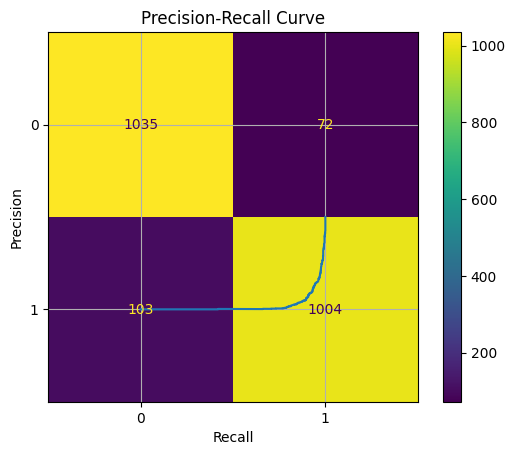

Baseline Accuracy: 0.5


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
from lightgbm import LGBMClassifier

# Step 1: Load the preprocessed, numerical dataset
df = pd.read_csv("final_training_ready_dataset.csv")

# Step 2: Shuffle the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 3: Split into features and target
X = df.drop("Cancer_Status", axis=1)
y = df["Cancer_Status"]

print("Features shape:", X.shape)
print("Target shape:", y.shape)

print(X)
print(y)

# Step 4: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 5: Train an LGBM classifier

model = LGBMClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


# Step 6: Evaluate the model
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 7: Save the trained model
joblib.dump(model, "cancer_detection_model_LGBM.pkl")
print("Model saved to cancer_detection_model_LGBM.pkl")

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

from sklearn.feature_selection import mutual_info_classif

info = mutual_info_classif(X, y)
for col, score in zip(X.columns, info):
    print(f"{col}: {score:.4f}")


# Sanity check with random guess baseline
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)

from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

probs = model.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, probs)
pr_auc = auc(recall, precision)

print("PR AUC:", pr_auc)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()


print("Baseline Accuracy:", accuracy_score(y_test, y_dummy))



XGBoost

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
from lightgbm import LGBMClassifier

# Step 1: Load the preprocessed, numerical dataset
df = pd.read_csv("final_training_ready_dataset.csv")

# Step 2: Shuffle the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 3: Split into features and target
X = df.drop("Cancer_Status", axis=1)
y = df["Cancer_Status"]

print("Features shape:", X.shape)
print("Target shape:", y.shape)

print(X)
print(y)

# Step 4: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 5: Train an XGBClassifier

from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)



# Step 6: Evaluate the model
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 7: Save the trained model
joblib.dump(model, "cancer_detection_model_XGB.pkl")
print("Model saved to cancer_detection_model_XGB.pkl")

# Sanity check with random guess baseline
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, y_dummy))



Features shape: (11066, 8)
Target shape: (11066,)
        Age  Gender  Obesity  Smoking_History  Alcohol_Consumption  Diabetes  \
0      55.0     0.0      0.0              1.0                  1.0       0.0   
1      80.0     0.0      0.0              0.0                  1.0       1.0   
2      53.0     0.0      1.0              0.0                  1.0       0.0   
3      64.0     0.0      0.0              1.0                  0.0       0.0   
4      69.0     1.0      0.0              0.0                  0.0       1.0   
...     ...     ...      ...              ...                  ...       ...   
11061  54.0     0.0      1.0              0.0                  1.0       0.0   
11062  64.0     1.0      0.0              1.0                  1.0       1.0   
11063  78.0     1.0      0.0              1.0                  0.0       1.0   
11064  52.0     0.0      1.0              0.0                  0.0       1.0   
11065  19.0     1.0      0.0              0.0                  0.0    

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:15:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Testing - Risk Quiz

In [ ]:
import joblib
import numpy as np

# Step 1: Ask user for each feature
def get_input(prompt, options=None, cast_type=float):
    while True:
        try:
            if options:
                print(prompt)
                for key, val in options.items():
                    print(f"  {key}: {val}")
                value = input("Enter choice: ").strip()
                if value not in options:
                    raise ValueError("Invalid choice.")
                return cast_type(value)
            else:
                return cast_type(input(prompt + ": ").strip())
        except ValueError:
            print("Invalid input. Try again.")

print("\nWelcome to the Pancreatic Cancer Risk Quiz\n")

# Features based on your dataset
age = get_input("Enter your age (years)", cast_type=float)
gender = get_input("Enter your gender", {"1": "Male", "0": "Female"}, cast_type=int)
obesity = get_input("Are you considered obese (BMI ≥ 30)?", {"1": "Yes", "0": "No"}, cast_type=int)
smoking = get_input("Have you ever smoked?", {"1": "Yes", "0": "No"}, cast_type=int)
alcohol = get_input("Do you consume alcohol?", {"1": "Yes", "0": "No"}, cast_type=int)
diabetes = get_input("Have you been diagnosed with diabetes?", {"1": "Yes", "0": "No"}, cast_type=int)
activity = get_input("Your physical activity level", {"2": "High", "1": "Medium", "0": "Low"}, cast_type=int)
healthcare = get_input("Your access to healthcare", {"2": "High", "1": "Medium", "0": "Low"}, cast_type=int)

# Format input to match training feature order
user_data = np.array([[age, gender, obesity, smoking, alcohol, diabetes, activity, healthcare]])

# Step 2: Load trained model
print("\nLoading model...")
model = joblib.load("cancer_detection_model_LGBM.pkl")

# Step 3: Make prediction
prediction = model.predict(user_data)[0]
probability = model.predict_proba(user_data)[0][int(prediction)]

# Step 4: Output result
print("\nPrediction Result:")
if prediction == 1:
    print(f"You are at **higher risk** of pancreatic cancer. (Confidence: {probability:.2%})")
    print("Please consider consulting a medical professional for follow-up screening.")
else:
    print(f"You are at **low risk** of pancreatic cancer. (Confidence: {probability:.2%})")

print("\nNote: This tool is not diagnostic. It's designed for educational and screening purposes only.")



Welcome to the Pancreatic Cancer Risk Quiz

Enter your age (years): 32
Enter your gender
  1: Male
  0: Female
Enter choice: 1
Are you considered obese (BMI ≥ 30)?
  1: Yes
  0: No
Enter choice: 0
Have you ever smoked?
  1: Yes
  0: No
Enter choice: 0
Do you consume alcohol?
  1: Yes
  0: No
Enter choice: 0
Have you been diagnosed with diabetes?
  1: Yes
  0: No
Enter choice: 0
Your physical activity level
  2: High
  1: Medium
  0: Low
Enter choice: 2
Your access to healthcare
  2: High
  1: Medium
  0: Low
Enter choice: 2

Loading model...

Prediction Result:
You are at **low risk** of pancreatic cancer. (Confidence: 99.94%)

Note: This tool is not diagnostic. It's designed for educational and screening purposes only.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Creating Synthetic Data Using Dataset

In [ ]:
import joblib
import numpy as np
import random
import pandas as pd

# Load model
model = joblib.load("cancer_detection_model_LGBM.pkl")

# Output file
output_file = "synthetic_patient_profiles.txt"

# Predefined mapping for explainability
gender_map = {1: "male", 0: "female"}
activity_map = {2: "high", 1: "medium", 0: "low"}
healthcare_map = {2: "good", 1: "moderate", 0: "poor"}

# Feature columns based on the model
columns = [
    "Age", "Gender", "Obesity", "Smoking_History", "Alcohol_Consumption", "Diabetes",
    "Physical_Activity_Level", "Access_to_Healthcare"
]

def generate_patient():
    return {
        "Age": random.randint(35, 85),
        "Gender": random.choice([0, 1]),
        "Obesity": random.choice([0, 1]),
        "Smoking_History": random.choice([0, 1]),
        "Alcohol_Consumption": random.choice([0, 1]),
        "Diabetes": random.choice([0, 1]),
        "Physical_Activity_Level": random.choice([0, 1, 2]),
        "Access_to_Healthcare": random.choice([0, 1, 2])
    }

def generate_summary(patient, risk_level):
    gender = gender_map[patient["Gender"]]
    activity = activity_map[patient["Physical_Activity_Level"]]
    access = healthcare_map[patient["Access_to_Healthcare"]]

    smoking = "smoker" if patient["Smoking_History"] else "non-smoker"
    alcohol = "drinks alcohol" if patient["Alcohol_Consumption"] else "does not drink alcohol"
    diabetes = "has diabetes" if patient["Diabetes"] else "does not have diabetes"
    obesity = "obese" if patient["Obesity"] else "not obese"

    risk_text = "high risk" if risk_level else "low risk"

    insight = (
        f"This patient profile indicates a {risk_text} of pancreatic cancer. "
        f"Patients with similar characteristics—especially those who are {obesity}, have diabetes, a history of smoking, "
        f"and limited access to healthcare—should be prioritized for early screening such as CT or MRI imaging, "
        f"and monitored using tumor markers like CA 19-9."
    )

    return (
        f"Patient: {patient['Age']}-year-old {gender}, {smoking}, {diabetes}, {alcohol}, {obesity}, "
        f"physically {activity} active, with {access} access to healthcare.\n"
        f"Risk Prediction: {risk_text.upper()}\n"
        f"Insight: {insight}\n"
        f"---\n"
    )

# Generate N synthetic records
N = 50
generated_texts = []

for _ in range(N):
    patient = generate_patient()
    df = pd.DataFrame([patient])[columns]
    prediction = int(model.predict(df)[0])
    summary = generate_summary(patient, prediction)
    generated_texts.append(summary)

# Save to text file
with open(output_file, "w") as f:
    f.writelines(generated_texts)

print(f"Generated {N} synthetic patient profiles in: {output_file}")


Generated 50 synthetic patient profiles in: synthetic_patient_profiles.txt


In [ ]:
!pip install cohere faiss-cpu xgboost pandas scikit-learn fastapi uvicorn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.9 MB/s eta 0:00:00


# Testing RAG + Synthetic Data

In [12]:
import cohere
import faiss
import numpy as np

# Step 1: Initialize Cohere client
co = cohere.Client("ezPOZNlxOzxqyu5EJ1bc4W33K0QH6Jgqh2fEtK9h")

# Step 2: Load and split synthetic RAG documents
with open("synthetic_patient_profiles.txt", "r") as f:
    documents = f.read().split("---\n")
documents = [doc.strip() for doc in documents if doc.strip()]

# Step 3: Embed documents
print("Embedding patient profiles...")
embeddings = co.embed(texts=documents, model="embed-english-v2.0").embeddings

# Step 4: Index embeddings using FAISS
dimension = len(embeddings[0])
index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings).astype("float32"))

# Step 5: New patient query
query = (
    "Patient is a 72-year-old male, diabetic and smoker, obese, with moderate healthcare access "
    "and low physical activity. Drinks alcohol occasionally."
)

query_embedding = co.embed(texts=[query], model="embed-english-v2.0").embeddings[0]
query_embedding = np.array([query_embedding]).astype("float32")

# Step 6: Search for top 2 similar cases
D, I = index.search(query_embedding, k=2)
top_matches = [documents[i] for i in I[0]]

# Step 7: Generate GenAI Explanation
prompt = f"""You are a helpful AI medical assistant reviewing a patient profile.

New Patient Profile:
{query}

Similar Patient Profiles:
{top_matches[0]}

{top_matches[1]}

Based on this information, provide:
- A clear risk level (low, medium, high)
- A brief medical insight
- A recommendation for next steps
"""

response = co.generate(
    prompt=prompt,
    model="command-r-plus",
    max_tokens=250,
    temperature=0.7
)

print("\nAI Explanation:\n", response.generations[0].text.strip())


Embedding patient profiles...

AI Explanation:
 Risk Level: HIGH RISK

Medical Insight: The patient's profile, a 72-year-old male, presents with multiple risk factors for pancreatic cancer. The presence of diabetes, smoking history, obesity, and low physical activity are all individual risk factors, and when combined, elevate his risk significantly. Additionally, his age and gender further increase the likelihood of pancreatic cancer development. Similar patient profiles with a subset of these risk factors have indicated a high risk of pancreatic cancer, and thus, this patient should be considered at high risk as well. 

Recommendation: Prioritize early screening for this patient, which may include CT or MRI imaging to detect any potential tumors or precancerous lesions. Additionally, recommend monitoring using tumor markers such as CA 19-9, which can help in early detection and subsequent treatment planning. Encourage the patient to address modifiable risk factors, such as smoking ces